In [14]:
import os
import pandas as pd
import luto.settings as settings
import rasterio
import numpy as np
from affine import Affine
import xarray as xr
from scipy.interpolate import interp1d
from plotnine import (
    ggplot, aes, geom_line, geom_point, geom_hline, facet_wrap,
    theme_bw, labs, theme, element_text, scale_color_brewer, scale_y_continuous, scale_color_manual
)

def update_geo_meta():
    """
    Update the geographic metadata based on the current settings.

    Note: When this function is called, the RESFACTOR is assumend to be > 1,
    because there is no need to update the metadata if the RESFACTOR is 1.

    Returns
        dict: The updated geographic metadata.
    """
    meta = GEO_META_FULLRES.copy()
    height, width =  LUMAP_2D_RESFACTORED.shape
    trans = list(GEO_META_FULLRES['transform'])
    trans[0] = trans[0] * settings.RESFACTOR    # Adjust the X resolution
    trans[4] = trans[4] * settings.RESFACTOR    # Adjust the Y resolution
    trans = Affine(*trans)
    meta.update(width=width, height=height, compress='lzw', driver='GTiff', transform=trans, nodata=NODATA, dtype='float32')
    return meta


C:\Users\s222552331\AppData\Local\Temp\35\ipykernel_231080\4141695906.py:77: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


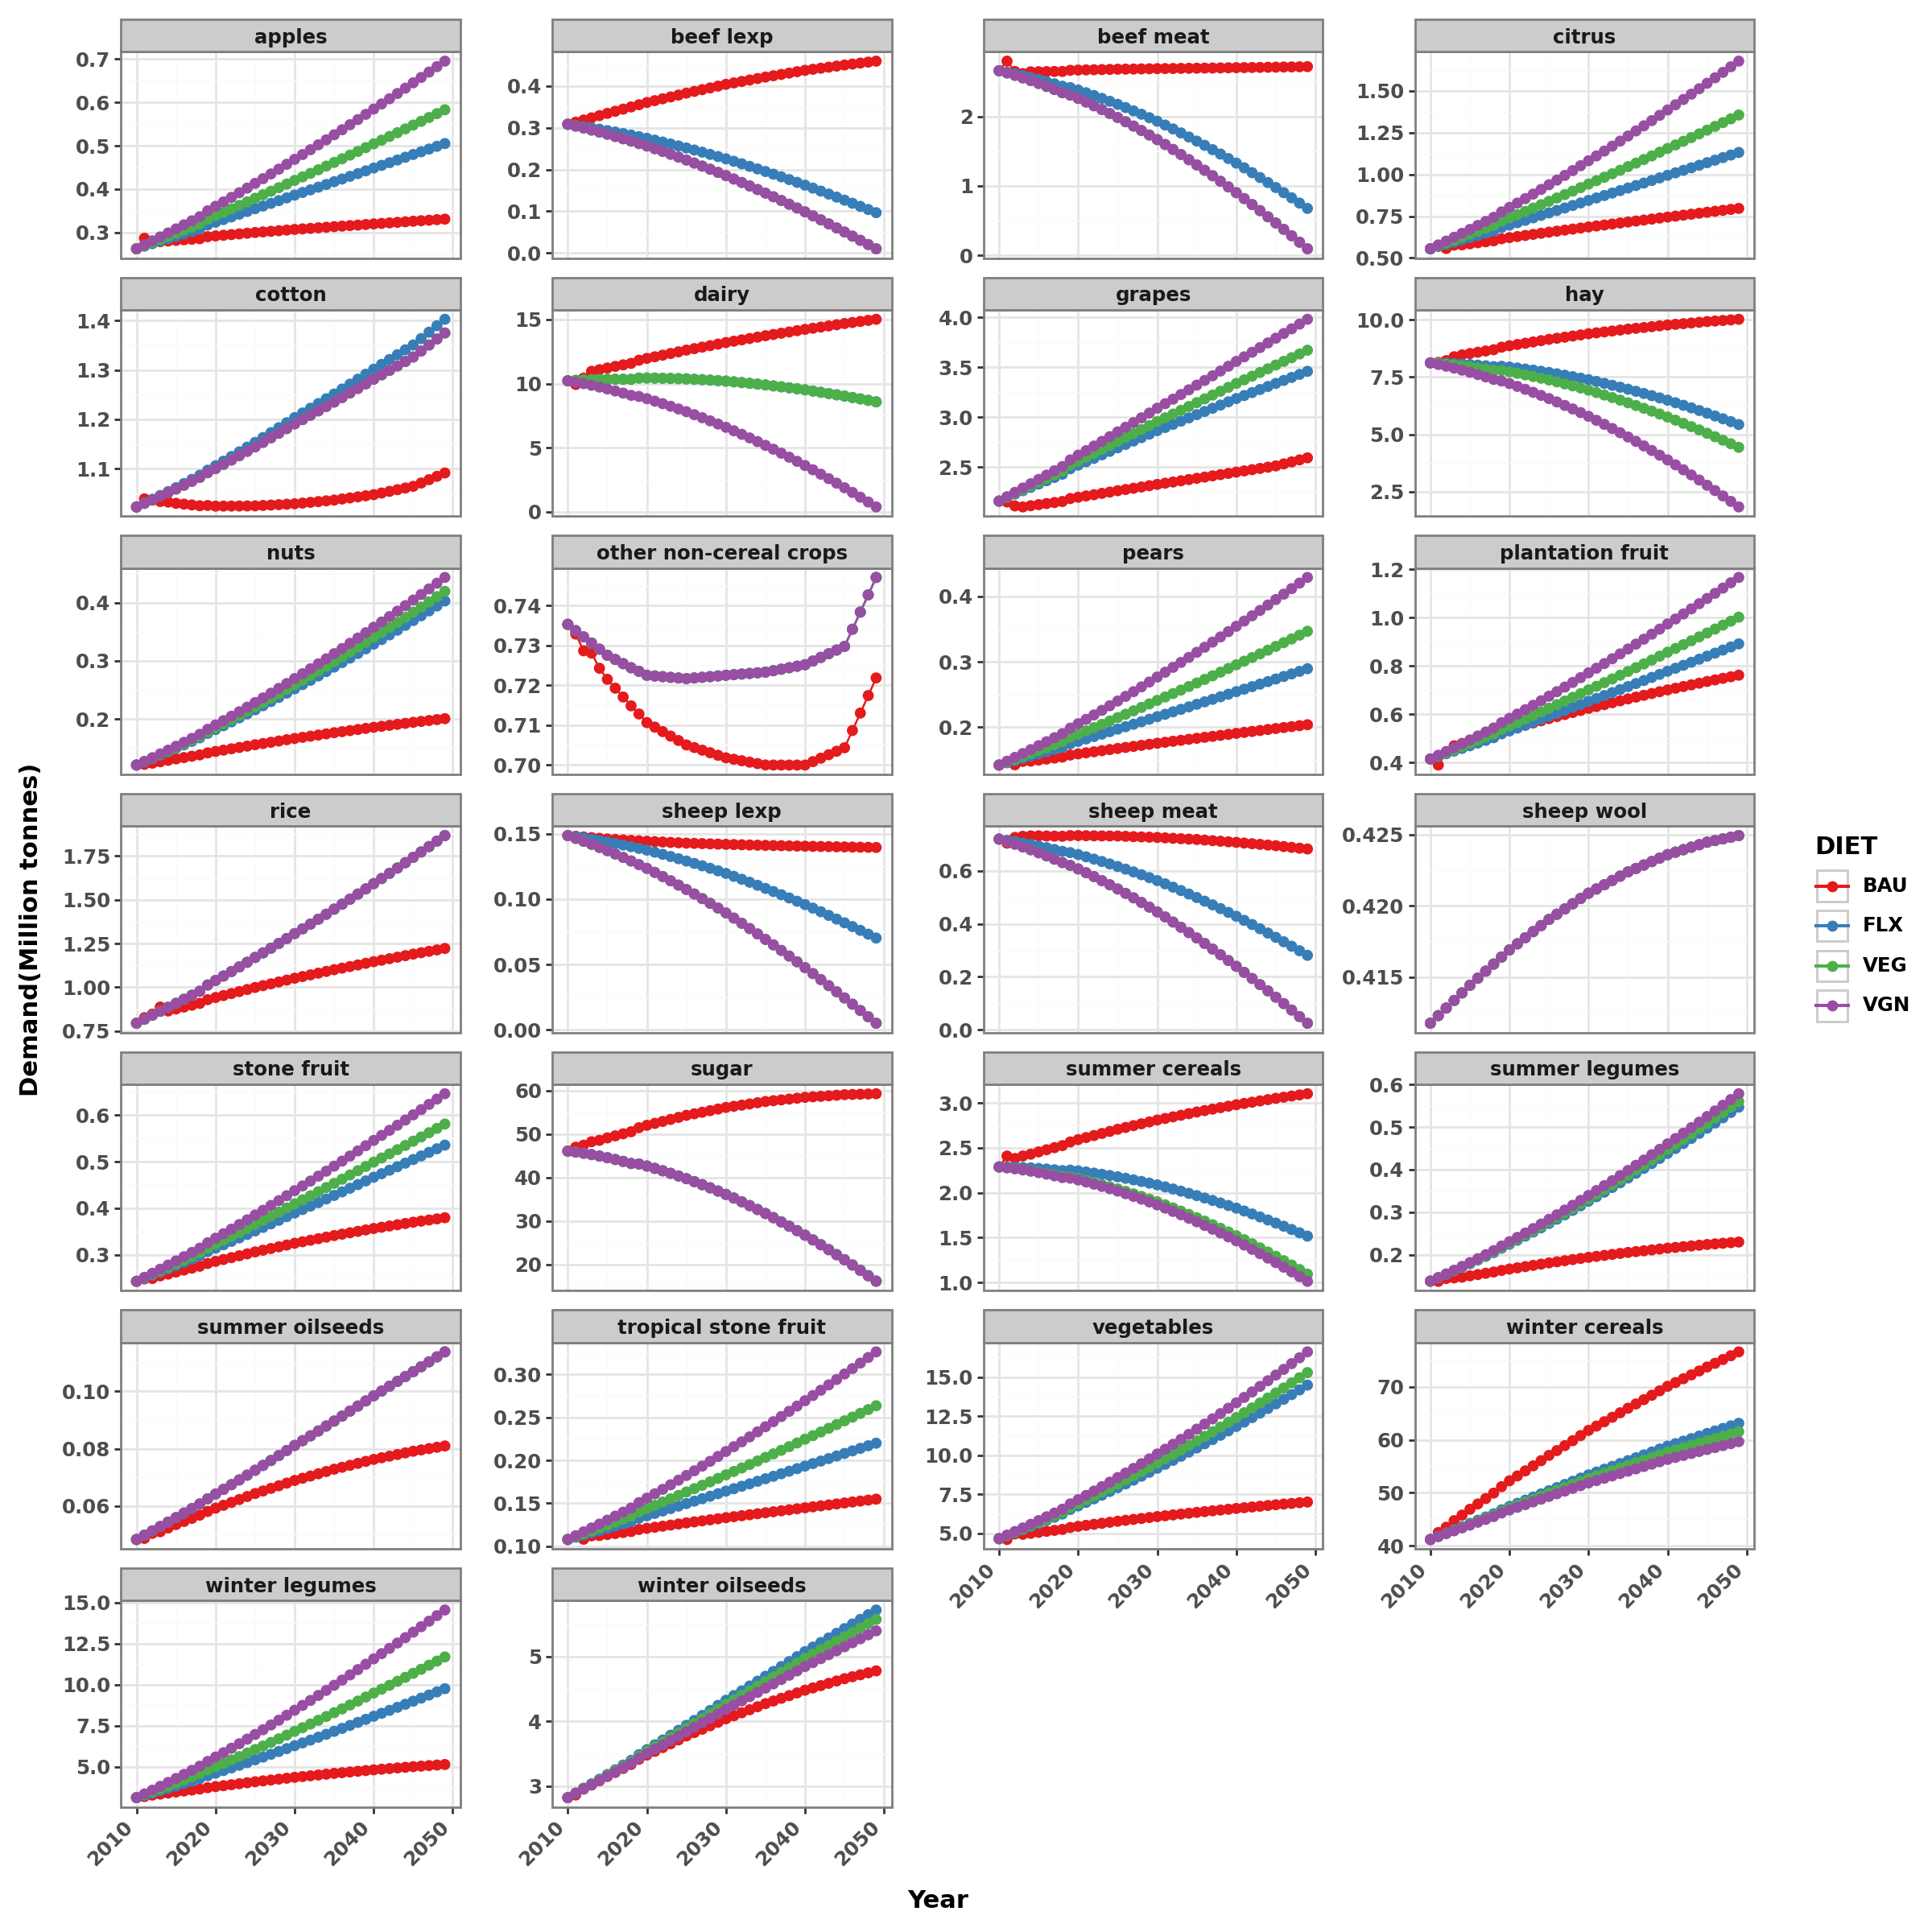

In [15]:
dd = pd.read_hdf(os.path.join(settings.INPUT_DIR, 'demand_projections.h5'))
DIETs = ['BAU', 'FLX', 'VEG', 'VGN']

# 1. Initialize an empty list to store the results from each loop
all_diets_data = []

for d in DIETs:
    # This part of your code remains the same
    DEMAND_DATA = dd.loc[(settings.SCENARIO,
                          d,
                          d,
                          settings.CONVERGENCE,
                          settings.IMPORT_TREND,
                          settings.WASTE,
                          settings.FEED_EFFICIENCY)].copy()
    DEMAND_DATA.loc['eggs'] = DEMAND_DATA.loc['eggs'] * settings.EGGS_AVG_WEIGHT / 1000 / 1000

    # Remove off-land commodities (this also remains the same)
    DEMAND_C = DEMAND_DATA.loc[DEMAND_DATA.query("COMMODITY not in @settings.OFF_LAND_COMMODITIES").index, 'PRODUCTION'].copy()

    # --- Start of new logic ---
    # 2. Convert the Series to a DataFrame and reset the index
    # This turns the 'COMMODITY' from the index into a column
    long_format_df = DEMAND_C.reset_index()

    # 3. Add a new column to identify the diet scenario
    long_format_df['DIET'] = d

    # 4. Append the DataFrame for the current diet to our list
    all_diets_data.append(long_format_df)
    # --- End of new logic ---

# 5. Concatenate all the DataFrames in the list into a single long table
final_long_table = pd.concat(all_diets_data, ignore_index=True)

df = final_long_table.melt(
    id_vars=['COMMODITY','DIET'],      # 保持不变的列
    var_name='YEAR',            # 新的列，用于存放年份
    value_name='Demand'     # 新的列，用于存放产量值
)
df["YEAR"] = df["YEAR"].astype(int)
df = df[df["YEAR"] < 2050]
df['Demand' ] = df['Demand' ] / 1e6  # 转换为百万吨

from plotnine import (
    ggplot, aes, geom_line, geom_point, facet_wrap,
    theme_bw, labs, theme, element_text, scale_color_brewer
)


# 按 COMMODITY, DIET, YEAR 汇总（如果已有唯一值可跳过）
agg = (
    df
    .groupby(["COMMODITY", "DIET", "YEAR"], as_index=False)
    .agg({'Demand' : "sum"})
)

# 绘图：每个作物一张子图，每张图有 4 条（对应不同 DIET），子图 y 轴独立（scales='free_y'）
p = (
    ggplot(agg, aes(x="YEAR", y='Demand', color="DIET", group="DIET"))
    + geom_line()
    + geom_point(size=1.8)
    + facet_wrap("~COMMODITY", scales="free_y", ncol=4)  # ncol 可调整列数
    + scale_color_brewer(type="qual", palette="Set1")
    + theme_bw()
    + labs(
        x="Year",
        y='Demand(Million tonnes)' ,
        color="DIET"
    )
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        figure_size=(12, 12)  # 指定输出图片的默认大小（英寸）
    )
)

print(p)

F:\xinhao\miniforge\envs\luto\Lib\site-packages\plotnine\scales\scales.py:48: PlotnineWarning: Scale for 'color' is already present.
Adding another scale for 'color',
which will replace the existing scale.

C:\Users\s222552331\AppData\Local\Temp\35\ipykernel_231080\2518919205.py:95: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


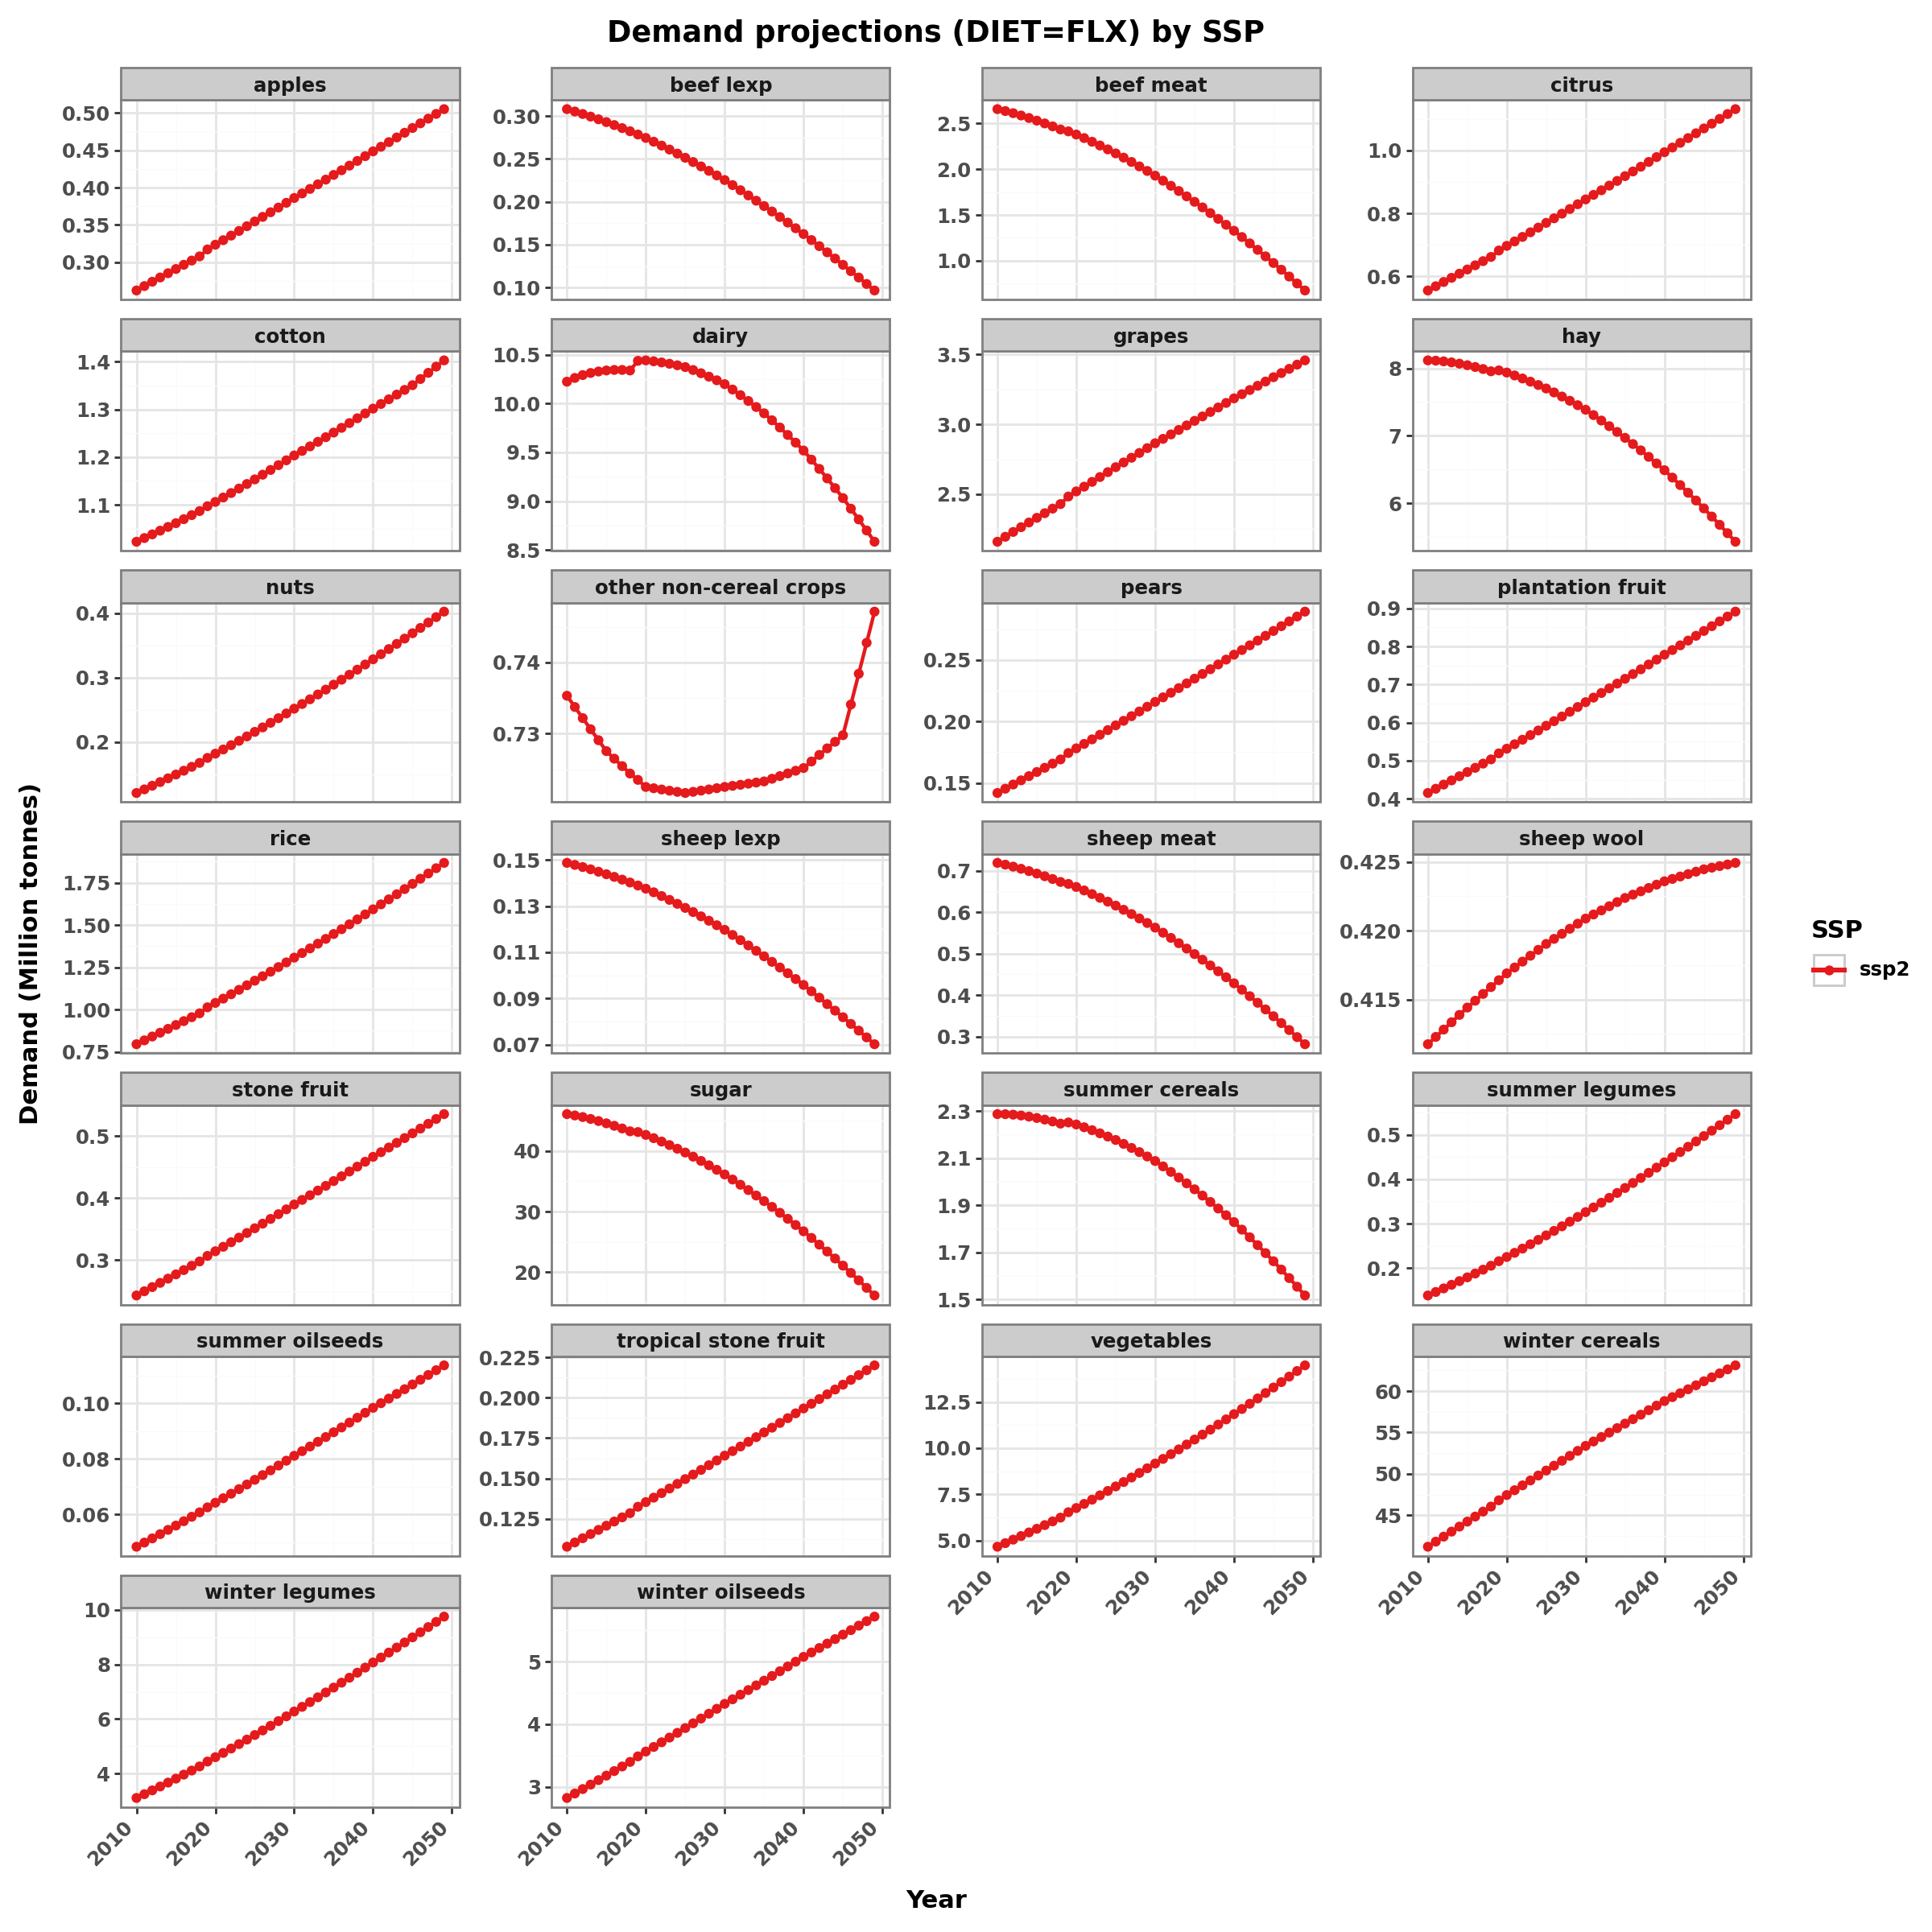

In [16]:
dd = pd.read_hdf(os.path.join(settings.INPUT_DIR, 'demand_projections.h5'))

# 目标：按照 SSP 分类（ssp1 - ssp5），只取 DIET = FLX 情景，合并成长表并绘图
SSP_LIST = ['ssp1', 'ssp2', 'ssp3', 'ssp4', 'ssp5']
DIET_TO_PLOT = 'FLX'

all_ssp_data = []

for s in SSP_LIST:
    # 注意：你的 dd 索引/层级可能使用大写 'SSP1'，如出错请改为 s.upper()
    scenario_key = s.upper()  # 如果你的数据使用小写，请改为 scenario_key = s

    DEMAND_DATA = dd.loc[
        (scenario_key,
         DIET_TO_PLOT,
         DIET_TO_PLOT,
         settings.CONVERGENCE,
         settings.IMPORT_TREND,
         settings.WASTE,
         settings.FEED_EFFICIENCY)
    ].copy()

    # 将 eggs 单位换算为吨（与原代码相同）
    if 'eggs' in DEMAND_DATA.index:
        DEMAND_DATA.loc['eggs'] = DEMAND_DATA.loc['eggs'] * settings.EGGS_AVG_WEIGHT / 1000 / 1000

    # 去掉 off-land commodities
    valid_index = DEMAND_DATA.query("COMMODITY not in @settings.OFF_LAND_COMMODITIES").index
    DEMAND_C = DEMAND_DATA.loc[valid_index, 'PRODUCTION'].copy()

    # 转换为 DataFrame 并重置索引（把 COMMODITY 和 YEAR 等变成列）
    long_format_df = DEMAND_C.reset_index()

    # 添加 SSP 标识列
    long_format_df['SSP'] = s  # 使用原始小写标签便于展示（ssp1..ssp5）

    all_ssp_data.append(long_format_df)

# 合并所有 SSP 的数据
if not all_ssp_data:
    raise RuntimeError("未读取到任何 SSP 数据，请检查 dd 索引和 SSP 列表（或大小写）")

final_long_table = pd.concat(all_ssp_data, ignore_index=True)

# 将宽格式的年份列展开为 YEAR / Demand（melt）
df = final_long_table.melt(
    id_vars=['COMMODITY', 'SSP'],   # 保持不变的列
    var_name='YEAR',
    value_name='Demand'
)

# 清理与类型转换
df["YEAR"] = df["YEAR"].astype(int)
df = df[df["YEAR"] < 2050]       # 只画 2050 年之前的
df['Demand'] = df['Demand'] / 1e6  # 转换为百万吨

# 按 COMMODITY, SSP, YEAR 汇总（若数据已经唯一，这步不会改变值）
agg = (
    df
    .groupby(["COMMODITY", "SSP", "YEAR"], as_index=False)
    .agg({'Demand': "sum"})
)

# 指定 SSP 的显示顺序（保持 ssp1..ssp5）
agg['SSP'] = pd.Categorical(agg['SSP'], categories=SSP_LIST, ordered=True)
SSP_COLORS = {
    'ssp1': '#1b9e77',  # 绿
    'ssp2': '#d95f02',  # 橙
    'ssp3': '#7570b3',  # 紫
    'ssp4': '#e7298a',  # 粉/品红
    'ssp5': '#66a61e',  # 深绿（与 ssp1 有区别）
}
# 绘图：每个作物一张子图（facet），每条线对应一个 SSP（颜色区分），子图 y 轴独立
p = (
    ggplot(agg, aes(x='YEAR', y='Demand', color='SSP', group='SSP'))
    + geom_line(size=0.9)        # 稍微细一点的线
    + geom_point(size=1.5)       # 小一点的点
    + facet_wrap('~COMMODITY', scales='free_y', ncol=4)
    + scale_color_manual(values=SSP_COLORS) 
    + scale_color_brewer(type='qual', palette='Set1')
    + theme_bw()
    + labs(
        x='Year',
        y='Demand (Million tonnes)',
        color='SSP',
        title=f'Demand projections (DIET={DIET_TO_PLOT}) by SSP'
    )
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        figure_size=(12, 12)
    )
)

print(p)

C:\Users\s222552331\AppData\Local\Temp\35\ipykernel_231080\2063940520.py:81: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


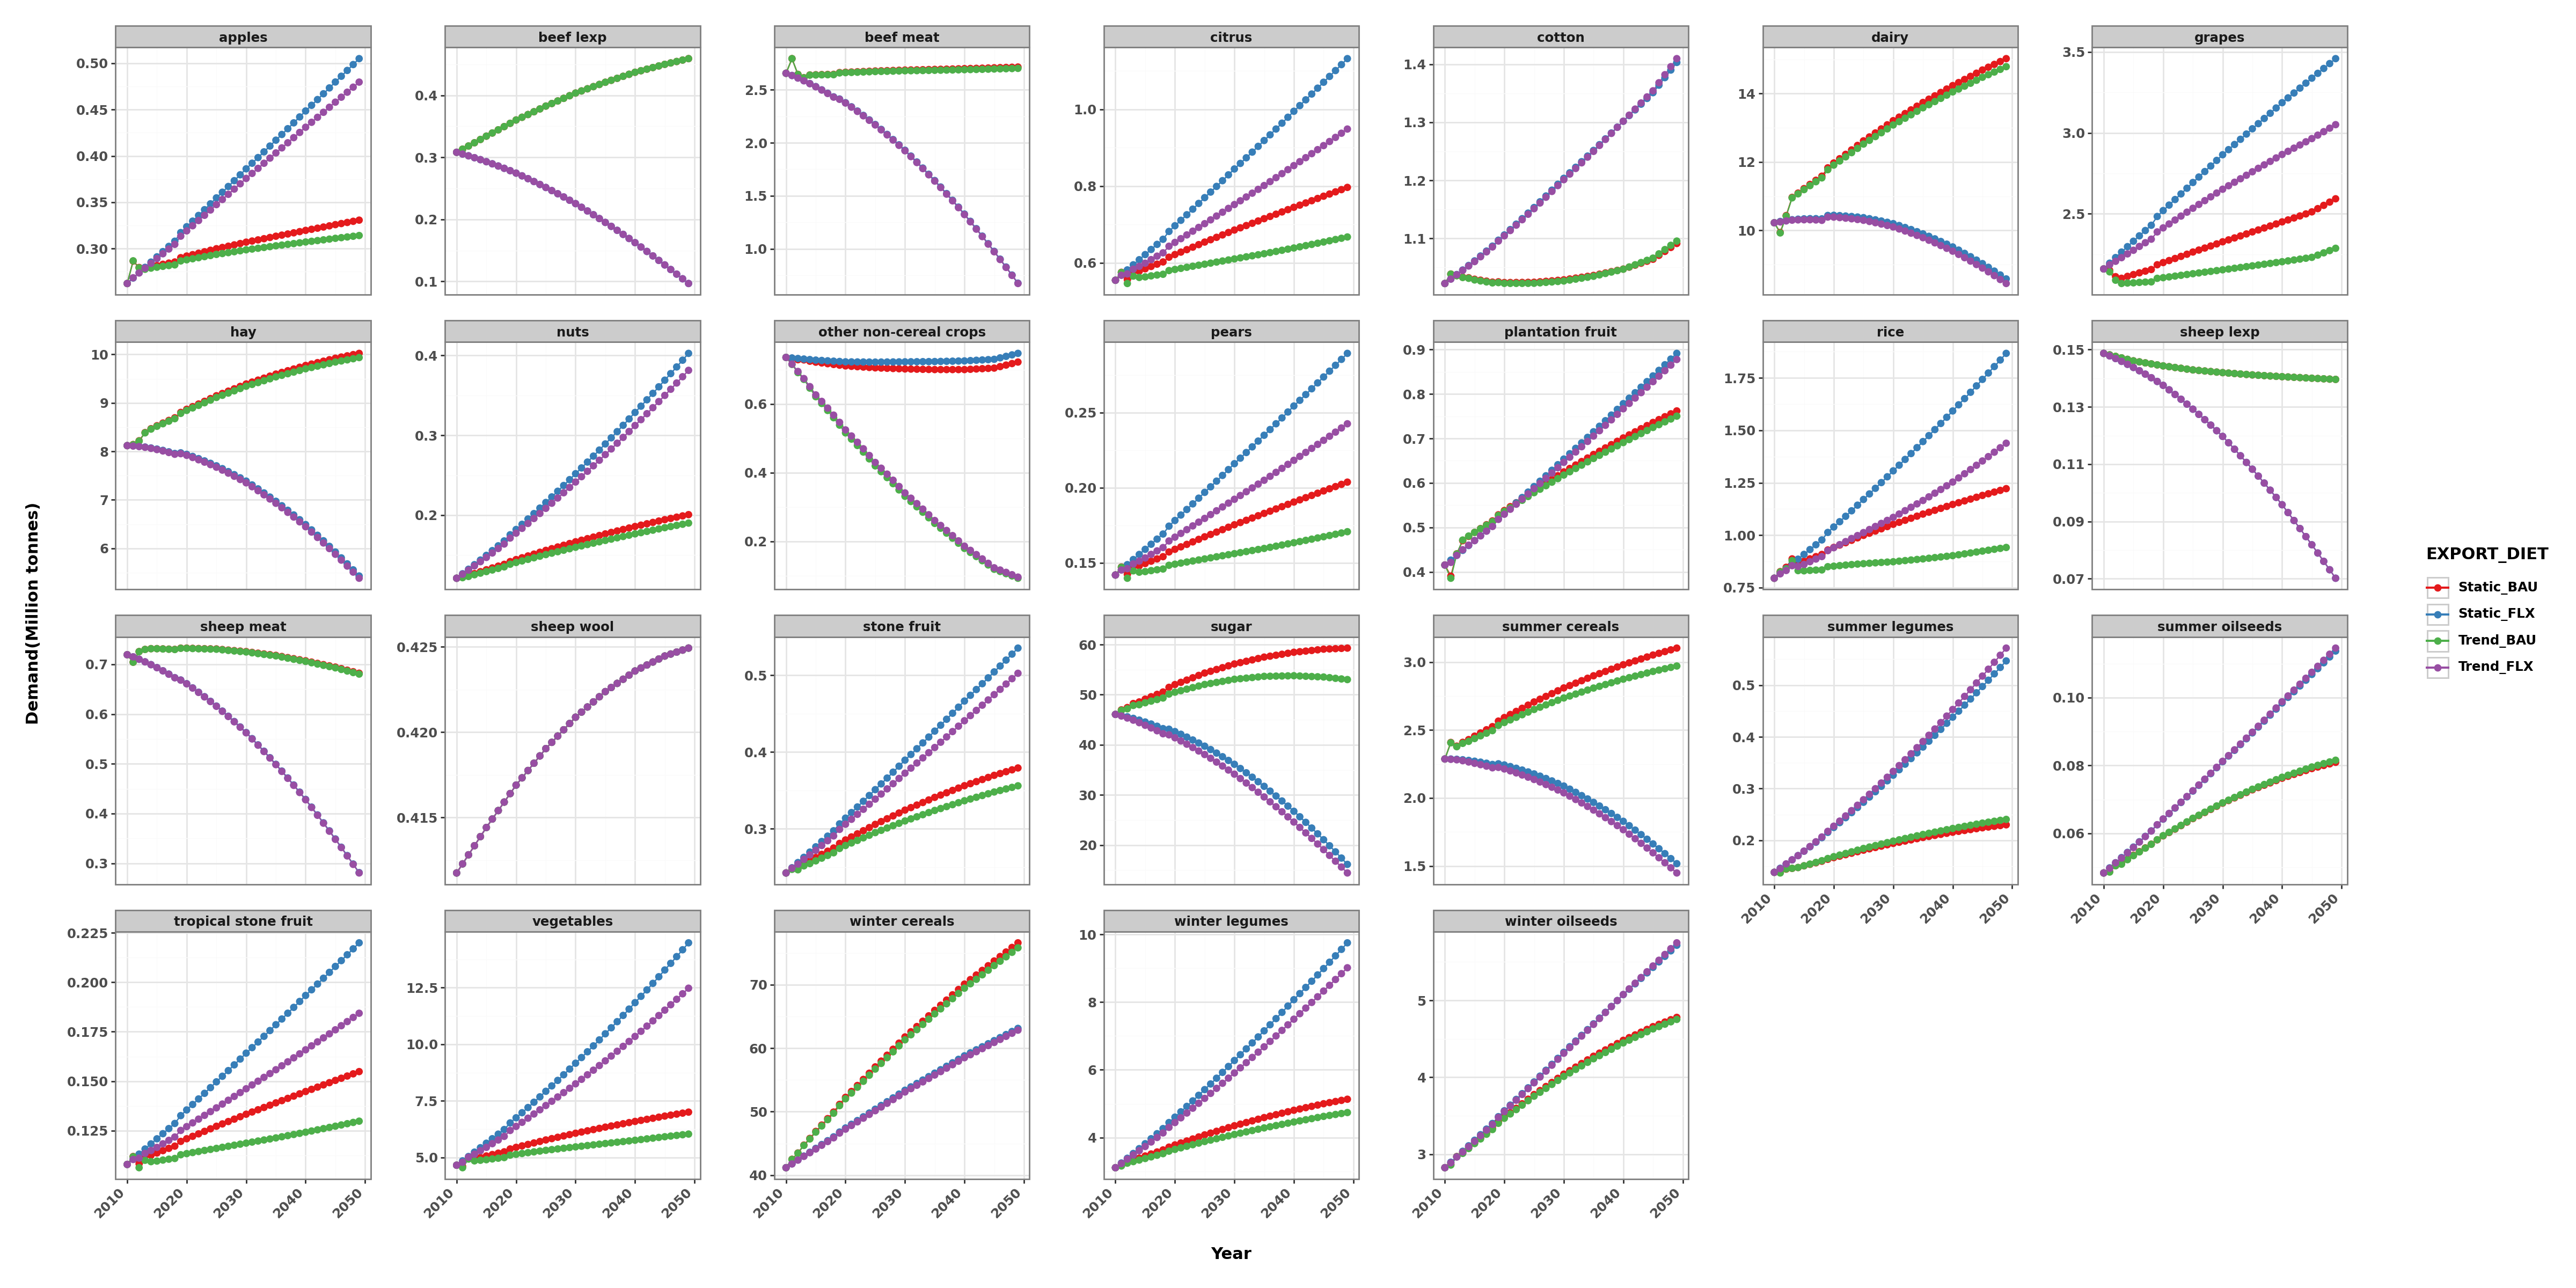

In [36]:
dd = pd.read_hdf(os.path.join(settings.INPUT_DIR, 'demand_projections.h5'))

# 目标：按照 SSP 分类（ssp1 - ssp5），只取 DIET = FLX 情景，合并成长表并绘图
# SSP_LIST = ['ssp1', 'ssp2', 'ssp3', 'ssp4', 'ssp5']
DIETs = ['BAU', 'FLX']
EXPORTs = ['Static','Trend']

all_diets_data = []

for d in DIETs:
    for e in EXPORTs:
        # This part of your code remains the same
        DEMAND_DATA = dd.loc[(settings.SCENARIO,
                              d,
                              d,
                              settings.CONVERGENCE,
                              e,
                              settings.WASTE,
                              settings.FEED_EFFICIENCY)].copy()
        DEMAND_DATA.loc['eggs'] = DEMAND_DATA.loc['eggs'] * settings.EGGS_AVG_WEIGHT / 1000 / 1000
    
        # Remove off-land commodities (this also remains the same)
        DEMAND_C = DEMAND_DATA.loc[DEMAND_DATA.query("COMMODITY not in @settings.OFF_LAND_COMMODITIES").index, 'PRODUCTION'].copy()
    
        # --- Start of new logic ---
        # 2. Convert the Series to a DataFrame and reset the index
        # This turns the 'COMMODITY' from the index into a column
        long_format_df = DEMAND_C.reset_index()
    
        # 3. Add a new column to identify the diet scenario
        long_format_df['EXPORT_DIET'] = f"{e}_{d}"
    
        # 4. Append the DataFrame for the current diet to our list
        all_diets_data.append(long_format_df)
        # --- End of new logic ---

# 5. Concatenate all the DataFrames in the list into a single long table
final_long_table = pd.concat(all_diets_data, ignore_index=True)

df = final_long_table.melt(
    id_vars=['COMMODITY','EXPORT_DIET'],      # 保持不变的列
    var_name='YEAR',            # 新的列，用于存放年份
    value_name='Demand'     # 新的列，用于存放产量值
)
df["YEAR"] = df["YEAR"].astype(int)
df = df[df["YEAR"] < 2050]
df['Demand' ] = df['Demand' ] / 1e6  # 转换为百万吨

from plotnine import (
    ggplot, aes, geom_line, geom_point, facet_wrap,
    theme_bw, labs, theme, element_text, scale_color_brewer
)


# 按 COMMODITY, DIET, YEAR 汇总（如果已有唯一值可跳过）
agg = (
    df
    .groupby(["COMMODITY", "EXPORT_DIET", "YEAR"], as_index=False)
    .agg({'Demand' : "sum"})
)

# 绘图：每个作物一张子图，每张图有 4 条（对应不同 DIET），子图 y 轴独立（scales='free_y'）
p = (
    ggplot(agg, aes(x="YEAR", y='Demand', color="EXPORT_DIET", group="EXPORT_DIET"))
    + geom_line()
    + geom_point(size=1.8)
    + facet_wrap("~COMMODITY", scales="free_y", ncol=7)  # ncol 可调整列数
    + scale_color_brewer(type="qual", palette="Set1")
    + theme_bw()
    + labs(
        x="Year",
        y='Demand(Million tonnes)' ,
        color="EXPORT_DIET"
    )
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        figure_size=(24, 12)  # 指定输出图片的默认大小（英寸）
    )
)

print(p)

In [31]:
df = final_long_table.melt(
    id_vars=['COMMODITY','EXPORT_DIET'],      # 保持不变的列
    var_name='YEAR',            # 新的列，用于存放年份
    value_name='Demand'     # 新的列，用于存放产量值
)

In [32]:
df

COMMODITY EXPORT_DIET  YEAR         Demand
0                    apples         NaN  2010   262,358.1418
1                 beef lexp         NaN  2010   308,146.9084
2                 beef meat         NaN  2010 2,655,505.3012
3                    citrus         NaN  2010   554,817.6437
4                    cotton         NaN  2010 1,022,519.8261
...                     ...         ...   ...            ...
76539  tropical stone fruit   Trend_FLX  DIET            NaN
76540            vegetables   Trend_FLX  DIET            NaN
76541        winter cereals   Trend_FLX  DIET            NaN
76542        winter legumes   Trend_FLX  DIET            NaN
76543       winter oilseeds   Trend_FLX  DIET            NaN

[76544 rows x 4 columns]

In [30]:
all_diets_data[-1]

YEAR               COMMODITY            2010            2011            2012            2013            2014            2015            2016            2017            2018            2019            2020            2021            2022            2023            2024            2025            2026            2027            2028            2029            2030            2031            2032            2033            2034            2035            2036  \
0                     apples    262,358.1418    268,510.7026    273,699.0775    278,903.8135    284,110.5760    289,263.0238    294,451.6981    299,570.4267    304,615.4114    313,437.2894    319,143.4438    324,683.7096    330,285.8363    335,949.7382    341,675.2990    347,462.3704    353,004.2292    358,602.7916    364,258.0622    369,970.0292    375,738.6637    381,144.9697    386,600.6407    392,105.7314    397,660.2870    403,264.3420    408,716.6366   
1                  beef lexp    308,146.9084    305,377.1209    302,476.7734    299,445.8659    296,284.3984    292,992.3708    289,569.7833    286,016.6357    282,332.9281    278,518.6604    274,573.8328    270,169.9667    265,651.9459    261,019.7705    256,273.4404    251,412.9557    246,438.3163    241,349.5223    236,146.5736    230,829.4702    225,398.2123    219,519.0943    213,548.0352    207,485.0349    201,330.0936    195,083.2111    188,744.3875   
2                  beef meat  2,655,505.3012  2,634,730.1701  2,610,642.8632  2,584,822.5305  2,557,377.5230  2,528,184.6417  2,497,399.0611  2,464,886.3654  2,430,671.3940  2,409,830.6773  2,374,887.4635  2,335,947.8574  2,295,809.3286  2,254,458.8841  2,211,883.3033  2,168,069.1338  2,121,797.9995  2,074,320.5326  2,025,625.3702  1,975,700.9734  1,924,535.6252  1,869,550.2567  1,813,473.5859  1,756,295.4903  1,698,005.7043  1,638,593.8175  1,577,607.6917   
3                     citrus    554,817.6437    567,796.3598    571,344.1949    583,638.3658    591,063.2687    599,232.4687    608,538.8989    617,543.5890    626,230.3857    643,388.9453    653,293.2461    663,067.2852    672,840.8140    682,608.7419    692,365.7919    702,106.4922    712,032.6838    721,975.7836    731,932.6074    741,899.8691    751,874.1759    761,715.2666    771,586.9783    781,487.6725    791,415.6588    801,369.1928    811,649.0372   
4                     cotton  1,022,519.8261  1,030,096.9450  1,037,589.9266  1,045,080.5792  1,052,622.7943  1,060,222.2909  1,068,555.9408  1,076,953.6990  1,085,416.3214  1,095,603.9687  1,104,522.0572  1,113,685.5285  1,122,942.6965  1,132,293.1473  1,141,736.4607  1,151,272.2094  1,161,076.5644  1,170,971.9608  1,180,958.0407  1,191,034.4414  1,201,200.7944  1,210,795.8867  1,220,461.4751  1,230,197.2466  1,240,002.8833  1,249,878.0620  1,260,135.2471   
5                      dairy 10,225,139.5017 10,249,969.1742 10,279,434.8170 10,301,208.8789 10,309,649.9111 10,313,024.5135 10,313,171.1365 10,307,588.0127 10,296,356.2648 10,391,251.1677 10,390,200.0720 10,376,105.0404 10,359,861.4962 10,341,429.2486 10,320,767.4419 10,297,834.5463 10,263,374.2618 10,226,673.8000 10,187,697.6975 10,146,409.9658 10,102,774.0850 10,044,467.7653  9,983,961.8869  9,921,224.5627  9,856,223.4706  9,788,925.8487  9,714,829.6438   
6                     grapes  2,159,898.4946  2,185,775.6685  2,207,070.2847  2,229,379.8590  2,252,752.8003  2,275,109.6119  2,298,883.6385  2,321,727.0190  2,343,605.8057  2,388,428.3132  2,413,328.3414  2,437,643.7982  2,461,924.1397  2,486,159.8944  2,510,341.2123  2,534,457.8501  2,558,013.2836  2,581,549.9468  2,605,061.6267  2,628,541.9005  2,651,984.1281  2,673,538.2905  2,695,104.6826  2,716,679.8274  2,738,260.1381  2,759,841.9146  2,781,147.2214   
7                        hay  8,118,464.4553  8,109,747.6003  8,099,016.3432  8,083,640.9613  8,062,005.9149  8,036,684.1763  8,008,340.0134  7,976,095.4071  7,940,001.4342  7,951,892.5309  7,917,844.1524  7,873,211.1399  7,826,420.9859  7,777,447.5772  7,726,264.3562  7,672,844.3141  7,

In [28]:
final_long_table

YEAR             COMMODITY            2010            2011            2012            2013            2014            2015            2016            2017            2018            2019            2020            2021            2022            2023            2024            2025            2026            2027            2028            2029            2030            2031            2032            2033            2034            2035            2036  \
0                   apples    262,358.1418    286,539.7448    279,635.4994    278,589.2147    280,289.6718    281,722.5319    283,083.2119    284,365.4886    285,571.4783    290,221.2754    291,976.9666    293,482.8495    295,026.5025    296,608.4422    298,229.1995    299,889.3150    301,230.9298    302,609.0023    304,023.9087    305,476.0193    306,965.6971    308,175.6428    309,420.8306    310,701.4679    312,017.7528    313,369.8739    314,559.9119   
1                beef lexp    308,146.9084    313,188.7022    318,312.9880    323,521.1157    328,814.4570    334,194.4061    339,248.0856    344,378.1866    349,585.8649    354,872.2936    360,238.6636    364,617.4043    369,049.3691    373,535.2050    378,075.5667    382,671.1169    386,784.1085    390,941.3069    395,143.1874    399,390.2301    403,682.9205    407,104.5847    410,555.2514    414,035.1662    417,544.5773    421,083.7346    424,252.7128   
2                beef meat  2,655,505.3012  2,793,553.7070  2,645,169.2576  2,614,114.1567  2,639,793.5361  2,641,633.5815  2,643,308.0968  2,644,545.0966  2,645,362.8646  2,662,158.0825  2,665,349.9290  2,667,474.8563  2,669,716.8410  2,672,079.3915  2,674,565.9408  2,677,179.8285  2,678,669.2536  2,680,288.8315  2,682,040.9584  2,683,927.8893  2,685,951.7383  2,686,920.6567  2,688,029.0205  2,689,278.0432  2,690,668.8108  2,692,202.2890  2,693,363.8330   
3                   citrus    554,817.6437    575,515.3331    556,384.4646    576,763.1370    578,548.4854    584,692.6063    590,768.7009    596,706.1731    602,504.7322    614,835.2923    621,730.7319    628,068.3734    634,484.7639    640,981.2873    647,559.3820    654,220.5306    660,345.0910    666,540.4829    672,807.9510    679,148.7474    685,564.1273    691,350.5594    697,200.6244    703,115.3256    709,095.6551    715,142.5926    720,931.8934   
4                   cotton  1,022,519.8261  1,038,784.2161  1,036,229.1961  1,033,444.6140  1,032,345.9192  1,029,807.5935  1,028,189.5117  1,026,546.2429  1,024,876.6263  1,025,404.3703  1,024,147.8269  1,024,186.2859  1,024,258.0527  1,024,363.4858  1,024,502.9713  1,024,676.9201  1,025,459.9228  1,026,266.2517  1,027,096.2881  1,027,950.4251  1,028,829.0660  1,030,304.8814  1,031,798.1269  1,033,309.1587  1,034,838.3371  1,036,386.0250  1,038,544.5184   
..                     ...             ...             ...             ...             ...             ...             ...             ...             ...             ...             ...             ...             ...             ...             ...             ...             ...             ...             ...             ...             ...             ...             ...             ...             ...             ...             ...             ...   
827   tropical stone fruit    107,851.8705    110,374.8234    111,064.4926    113,454.3758    114,897.7143    116,485.7379    118,294.8294    120,045.2652    121,733.9052    125,069.3845    126,994.6970    128,894.6878    130,794.5794    132,693.3822    134,590.0704    136,483.5804    138,413.1483    140,346.0030    142,281.5256    144,219.0772    146,157.9983    148,071.0234    149,990.0008    151,914.6123    153,844.5291    155,779.4122    157,777.7272   
828             vegetables  4,661,214.2332  4,793,121.6033  5,014,533.2361  5,148,362.7630  5,299,509.5759  5,448,736.8352  5,612,431.4044  5,774,354.8848  5,934,159.8581  6,195,306.5994  6,374,313.4811  6,554,970.3439  6,737,577.9131  6,922,092.5531  7,108,467.0725  7,296,650.5506  7,484,568.6701  7,67

In [23]:
long_format_df

YEAR               COMMODITY            2010            2011            2012            2013            2014            2015            2016            2017            2018            2019            2020            2021            2022            2023            2024            2025            2026            2027            2028            2029            2030            2031            2032            2033            2034            2035            2036  \
0                     apples    262,358.1418    271,742.6055    280,243.1201    288,839.6112    297,516.3276    306,212.3373    315,021.3752    323,828.6732    332,626.5289    345,647.8941    355,355.5546    364,955.9412    374,701.0256    384,591.4444    394,627.7894    404,810.6042    414,780.9344    424,887.2237    435,130.0863    445,510.1124    456,027.8657    466,171.4527    476,437.2423    486,825.8190    497,337.7526    507,973.5975    518,478.0471   
1                  beef lexp    308,146.9084    303,692.1636    299,070.8072    294,282.8390    289,328.2592    284,207.0677    278,919.2645    273,464.8496    267,843.8230    262,056.1847    256,101.9348    249,677.5098    243,107.4086    236,391.6311    229,530.1773    222,523.0472    215,370.2408    208,071.7581    200,627.5991    193,037.7639    185,302.2523    177,151.7645    168,883.9477    160,498.8020    151,996.3274    143,376.5239    134,639.3914   
2                  beef meat  2,655,505.3012  2,623,833.0420  2,588,600.0470  2,551,384.9036  2,512,296.0728  2,471,215.3925  2,428,297.1950  2,383,411.5225  2,336,585.8202  2,302,565.0350  2,254,429.1676  2,202,193.9295  2,148,527.9022  2,093,416.8775  2,036,846.4006  1,978,801.7668  1,918,121.1244  1,856,004.6876  1,792,440.0620  1,727,414.6631  1,660,915.7141  1,590,762.6193  1,519,322.7600  1,446,585.0960  1,372,538.4319  1,297,171.4157  1,220,085.1948   
3                     citrus    554,817.6437    577,077.9509    589,861.1148    611,766.6221    628,719.5737    646,548.3426    665,714.2873    684,669.4527    703,379.0755    731,908.2431    752,364.8561    772,803.9810    793,370.3040    814,055.5797    834,851.1624    855,747.9890    876,975.2047    898,342.2453    919,843.7885    941,474.2877    963,227.9628    984,927.5081  1,006,775.1590  1,028,768.2408  1,050,903.9661  1,073,179.4301  1,095,982.5094   
4                     cotton  1,022,519.8261  1,029,572.8451  1,036,529.8714  1,043,472.6899  1,050,455.1967  1,057,483.3207  1,065,233.8984  1,073,037.0707  1,080,893.7020  1,090,450.1410  1,098,734.9953  1,107,260.4790  1,115,868.6880  1,124,559.1580  1,133,331.4173  1,142,184.9863  1,151,298.3907  1,160,491.9653  1,169,765.3095  1,179,118.0166  1,188,549.6744  1,197,418.3507  1,206,348.3235  1,215,339.2419  1,224,390.7492  1,233,502.4828  1,242,989.1270   
5                      dairy 10,225,139.5017 10,107,320.8062  9,990,164.2635  9,861,497.2731  9,716,179.5927  9,562,327.3758  9,401,697.8470  9,232,040.8835  9,053,547.3706  8,964,466.3305  8,785,447.5947  8,591,186.8299  8,391,018.8820  8,184,856.9903  7,972,613.1290  7,754,197.9962  7,522,507.9477  7,284,904.3789  7,041,311.4165  6,791,652.1633  6,535,848.6890  6,266,225.3112  5,991,014.8947  5,710,149.4306  5,423,560.0441  5,131,176.9866  4,830,546.8339   
6                     grapes  2,159,898.4946  2,194,471.0777  2,224,618.5990  2,255,945.3423  2,288,509.3681  2,320,200.7564  2,353,495.9030  2,385,994.5717  2,417,647.5856  2,473,517.9820  2,508,782.0060  2,543,621.3224  2,578,602.2079  2,613,714.4153  2,648,947.1541  2,684,289.0667  2,719,155.6466  2,754,167.4990  2,789,317.7733  2,824,599.3018  2,860,004.5871  2,893,547.8585  2,927,255.1249  2,961,122.6781  2,995,146.6380  3,029,322.9460  3,063,295.4124   
7                        hay  8,118,464.4553  8,045,521.3788  7,968,879.5833  7,885,959.4312  7,795,305.0122  7,699,445.9991  7,599,020.4064  7,493,234.7149  7,382,177.6169  7,313,042.1423  7,199,700.6012  7,074,918.6717  6,946,402.7694  6,814,110.7541  6,677,999.8342  6,538,026.5603  6,

In [27]:
df

COMMODITY EXPORT_DIET  YEAR         Demand
0                    apples         NaN  2010   262,358.1418
1                 beef lexp         NaN  2010   308,146.9084
2                 beef meat         NaN  2010 2,655,505.3012
3                    citrus         NaN  2010   554,817.6437
4                    cotton         NaN  2010 1,022,519.8261
...                     ...         ...   ...            ...
76539  tropical stone fruit   Trend_FLX  DIET            NaN
76540            vegetables   Trend_FLX  DIET            NaN
76541        winter cereals   Trend_FLX  DIET            NaN
76542        winter legumes   Trend_FLX  DIET            NaN
76543       winter oilseeds   Trend_FLX  DIET            NaN

[76544 rows x 4 columns]

In [20]:
final_long_table

YEAR             COMMODITY            2010            2011            2012            2013            2014            2015            2016            2017            2018            2019            2020            2021            2022            2023            2024            2025            2026            2027            2028            2029            2030            2031            2032            2033            2034            2035            2036  \
0                   apples    262,358.1418    286,539.7448    279,635.4994    278,589.2147    280,289.6718    281,722.5319    283,083.2119    284,365.4886    285,571.4783    290,221.2754    291,976.9666    293,482.8495    295,026.5025    296,608.4422    298,229.1995    299,889.3150    301,230.9298    302,609.0023    304,023.9087    305,476.0193    306,965.6971    308,175.6428    309,420.8306    310,701.4679    312,017.7528    313,369.8739    314,559.9119   
1                beef lexp    308,146.9084    313,188.7022    318,312.9880    323,521.1157    328,814.4570    334,194.4061    339,248.0856    344,378.1866    349,585.8649    354,872.2936    360,238.6636    364,617.4043    369,049.3691    373,535.2050    378,075.5667    382,671.1169    386,784.1085    390,941.3069    395,143.1874    399,390.2301    403,682.9205    407,104.5847    410,555.2514    414,035.1662    417,544.5773    421,083.7346    424,252.7128   
2                beef meat  2,655,505.3012  2,793,553.7070  2,645,169.2576  2,614,114.1567  2,639,793.5361  2,641,633.5815  2,643,308.0968  2,644,545.0966  2,645,362.8646  2,662,158.0825  2,665,349.9290  2,667,474.8563  2,669,716.8410  2,672,079.3915  2,674,565.9408  2,677,179.8285  2,678,669.2536  2,680,288.8315  2,682,040.9584  2,683,927.8893  2,685,951.7383  2,686,920.6567  2,688,029.0205  2,689,278.0432  2,690,668.8108  2,692,202.2890  2,693,363.8330   
3                   citrus    554,817.6437    575,515.3331    556,384.4646    576,763.1370    578,548.4854    584,692.6063    590,768.7009    596,706.1731    602,504.7322    614,835.2923    621,730.7319    628,068.3734    634,484.7639    640,981.2873    647,559.3820    654,220.5306    660,345.0910    666,540.4829    672,807.9510    679,148.7474    685,564.1273    691,350.5594    697,200.6244    703,115.3256    709,095.6551    715,142.5926    720,931.8934   
4                   cotton  1,022,519.8261  1,038,784.2161  1,036,229.1961  1,033,444.6140  1,032,345.9192  1,029,807.5935  1,028,189.5117  1,026,546.2429  1,024,876.6263  1,025,404.3703  1,024,147.8269  1,024,186.2859  1,024,258.0527  1,024,363.4858  1,024,502.9713  1,024,676.9201  1,025,459.9228  1,026,266.2517  1,027,096.2881  1,027,950.4251  1,028,829.0660  1,030,304.8814  1,031,798.1269  1,033,309.1587  1,034,838.3371  1,036,386.0250  1,038,544.5184   
..                     ...             ...             ...             ...             ...             ...             ...             ...             ...             ...             ...             ...             ...             ...             ...             ...             ...             ...             ...             ...             ...             ...             ...             ...             ...             ...             ...             ...   
515   tropical stone fruit    107,851.8705    112,179.0865    114,664.0257    118,922.2716    122,217.7824    125,683.5447    129,409.2427    133,093.9670    136,730.9598    142,276.7894    146,253.3824    150,226.5759    154,224.4956    158,245.5388    162,288.0247    166,350.1915    170,476.5832    174,630.1557    178,809.8743    183,014.6609    187,243.3919    191,461.6005    195,708.5996    199,983.8692    204,286.8675    208,617.0298    213,049.7561   
516             vegetables  4,661,214.2332  4,827,825.8049  5,085,467.1090  5,255,122.7230  5,442,773.3589  5,628,841.8972  5,830,288.3478  6,030,367.3109  6,228,652.9950  6,534,433.9998  6,754,347.4673  6,976,517.3471  7,201,254.2494  7,428,506.7436  7,658,219.0386  7,890,330.7749  8,122,564.9311  8,35

In [19]:
df

COMMODITY DIET         YEAR         Demand
0                    apples  BAU         2010   262,358.1418
1                 beef lexp  BAU         2010   308,146.9084
2                 beef meat  BAU         2010 2,655,505.3012
3                    citrus  BAU         2010   554,817.6437
4                    cotton  BAU         2010 1,022,519.8261
...                     ...  ...          ...            ...
47835  tropical stone fruit  NaN  EXPORT_DIET      Trend_VGN
47836            vegetables  NaN  EXPORT_DIET      Trend_VGN
47837        winter cereals  NaN  EXPORT_DIET      Trend_VGN
47838        winter legumes  NaN  EXPORT_DIET      Trend_VGN
47839       winter oilseeds  NaN  EXPORT_DIET      Trend_VGN

[47840 rows x 4 columns]

C:\Users\s222552331\AppData\Local\Temp\35\ipykernel_231080\3693302677.py:59: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
C:\Users\s222552331\AppData\Local\Temp\35\ipykernel_231080\3693302677.py:59: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
C:\Users\s222552331\AppData\Local\Temp\35\ipykernel_231080\3693302677.py:59: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
C:\Users\s222552331\AppData\Local\Temp\35\ipykernel_231080\3693302677.py:59: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
C:\Users\s222552331\AppData\Local\Temp\35\ipykernel_231080\3693302677.py:124: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


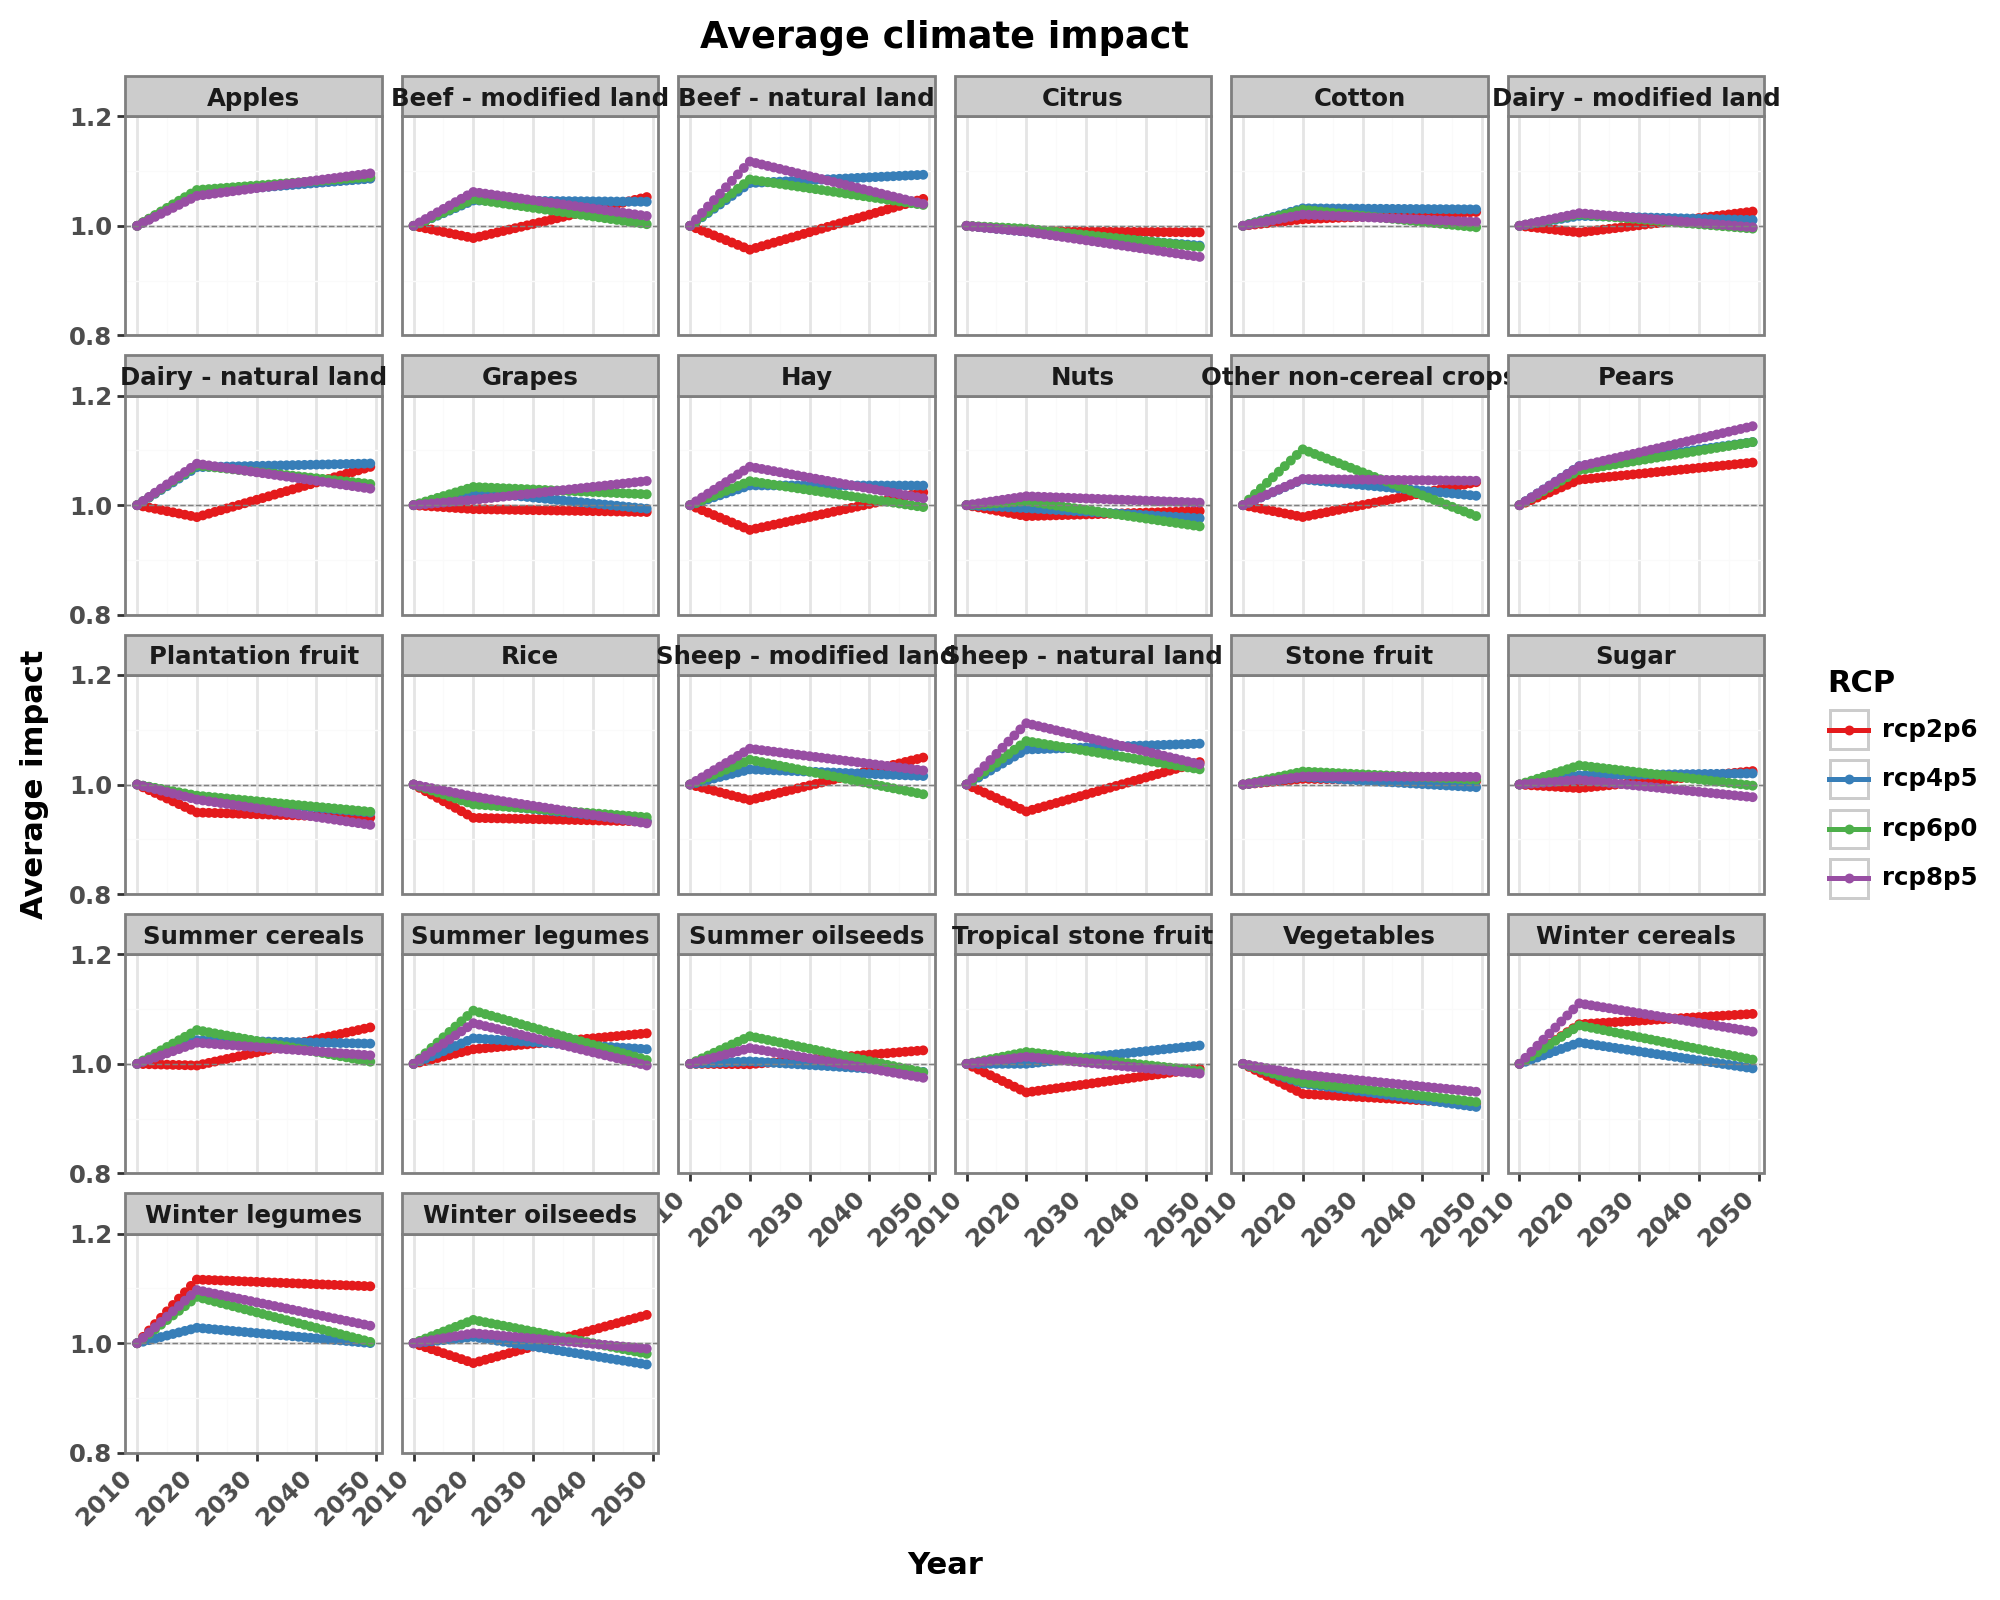

In [4]:
# Set resfactor multiplier
RESMULT = settings.RESFACTOR ** 2

# Set the nodata and non-ag code
NODATA = -9999
MASK_LU_CODE = -1

# Load LUMAP without resfactor
LUMAP_NO_RESFACTOR = pd.read_hdf(os.path.join(settings.INPUT_DIR, "lumap.h5")).to_numpy().astype(np.int8)   # 1D (ij flattend),  0-27 for land uses; -1 for non-agricultural land uses; All cells in Australia (land only)

# NLUM mask.
with rasterio.open(os.path.join(settings.INPUT_DIR, "NLUM_2010-11_mask.tif")) as rst:
    NLUM_MASK = rst.read(1).astype(np.int8)                                                                # 2D map,  0 for ocean, 1 for land
    LUMAP_2D_FULLRES = np.full_like(NLUM_MASK, NODATA, dtype=np.int16)                           # 2D map,  full of nodata (-9999)
    np.place(LUMAP_2D_FULLRES, NLUM_MASK == 1, LUMAP_NO_RESFACTOR)                               # 2D map,  -9999 for ocean; -1 for desert, urban, water, etc; 0-27 for land uses
    GEO_META_FULLRES = rst.meta                                                                            # dict,  key-value pairs of geospatial metadata for the full resolution land-use map
    GEO_META_FULLRES['dtype'] = 'float32'                                                                  # Set the data type to float32
    GEO_META_FULLRES['nodata'] = NODATA                                                               # Set the nodata value to -9999

# Mask out non-agricultural, non-environmental plantings land (i.e., -1) from lumap 
# (True means included cells. Boolean dtype.)
LUMASK = LUMAP_NO_RESFACTOR != MASK_LU_CODE                                                      # 1D (ij flattend);  `True` for land uses; `False` for desert, urban, water, etc

# Return combined land-use and resfactor mask
if settings.RESFACTOR > 1:
    rf_mask = NLUM_MASK.copy()
    nonzeroes = np.nonzero(rf_mask)
    rf_mask[int(settings.RESFACTOR/2)::settings.RESFACTOR, int(settings.RESFACTOR/2)::settings.RESFACTOR] = 0
    resmask = np.where(rf_mask[nonzeroes] == 0, True, False)
    MASK = LUMASK * resmask
    LUMAP_2D_RESFACTORED = LUMAP_2D_FULLRES[int(settings.RESFACTOR/2)::settings.RESFACTOR, int(settings.RESFACTOR/2)::settings.RESFACTOR]
    GEO_META = update_geo_meta()
elif settings.RESFACTOR == 1:
    MASK = LUMASK
    GEO_META = GEO_META_FULLRES
    LUMAP_2D_RESFACTORED = LUMAP_2D_FULLRES
else:
    raise KeyError("Resfactor setting invalid")


RCP_LIST = ["rcp2p6", "rcp4p5", "rcp6p0", "rcp8p5"]
YR_CAL_BASE = 2010

results_list = []

for rcp in RCP_LIST:
    h5name = f"climate_change_impacts_{rcp}_CO2_FERT_{settings.CO2_FERT.upper()}.h5"
    h5path = os.path.join(settings.INPUT_DIR, h5name)

    # 读取数据（若需要筛选则使用 where=MASK）
    if MASK is not None:
        CLIMATE_CHANGE_IMPACT = pd.read_hdf(h5path, where=MASK)
    else:
        CLIMATE_CHANGE_IMPACT = pd.read_hdf(h5path)

    CLIMATE_CHANGE_IMPACT.columns.names = ['management', 'land_use', 'year']

    # 按 land_use 和 year 聚合（对列级别聚合，再对行取平均）
    aggregated_series = CLIMATE_CHANGE_IMPACT.groupby(axis=1, level=['land_use', 'year']).mean().mean(axis=0)
    avg_impact_wide = aggregated_series.unstack(level='land_use')

    # 尝试把年份 index 转为整数
    try:
        years_index = list(map(int, avg_impact_wide.index.tolist()))
        avg_impact_wide.index = years_index
    except Exception:
        pass

    start_year = YR_CAL_BASE
    end_year = int(avg_impact_wide.index.max())
    years_to_interpolate = np.arange(start_year, end_year + 1)

    for land_use in avg_impact_wide.columns:
        # 已知点：2010 -> 1.0，后面是原始年份点
        x_known = [YR_CAL_BASE] + list(avg_impact_wide.index)
        y_known = [1.0] + list(avg_impact_wide[land_use].values)

        f = interp1d(x_known, y_known, kind='linear', fill_value='extrapolate', bounds_error=False)
        interpolated_impacts = f(years_to_interpolate)

        for i, year in enumerate(years_to_interpolate):
            results_list.append({
                'rcp': rcp,
                'land_use': land_use,
                'year': int(year),
                'average_impact': float(interpolated_impacts[i])
            })

# 合并为 DataFrame
final_long_df = pd.DataFrame(results_list)

if final_long_df.empty:
    raise RuntimeError("未生成任何数据：请检查输入文件和 MASK 设置。")

# 只保留 2050 年之前的数据（如果你不想要这个过滤，可以注释下一行）
final_long_df = final_long_df[final_long_df['year'] < 2050]

# 指定 RCP 顺序
final_long_df['rcp'] = pd.Categorical(final_long_df['rcp'], categories=RCP_LIST, ordered=True)

# 绘图：所有子图使用相同 y 轴范围 [0, 1.2]，并显示 y=1，线较细，点较小
p = (
    ggplot(final_long_df, aes(x='year', y='average_impact', color='rcp', group='rcp'))
    + geom_line(size=0.7)        # 线细一些
    + geom_point(size=1.0)       # 点小一些
    + geom_hline(yintercept=1.0, linetype='dashed', color='gray', size=0.3)  # 确保 y=1 可见
    + facet_wrap('~land_use', scales='fixed', ncol=6)  # 相同 y 轴（scales='fixed'）
    + scale_color_brewer(type='qual', palette='Set1')
    + scale_y_continuous(limits=(0.8, 1.2), breaks=[0.8, 1.0, 1.2], expand=(0, 0))
    + theme_bw()
    + labs(
        title='Average climate impact',
        x='Year',
        y='Average impact',
        color='RCP'
    )
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        figure_size=(10, 8)
    )
)

# 在交互式环境下直接显示（可选）
print(p)

2010-2024年期间的分析:
年均增长率 (Mean): 3.79%
增长率标准差 (Std Dev): 2.66%

基于数据波动性定义的四种未来增长情景:
低增长情景 (Mean - 0.5*Std): 3.53%
中等增长情景 (Mean): 3.79%
高增长情景 (Mean + 0.5*Std): 4.06%
非常高增长情景 (Mean + 1.0*Std): 4.32%


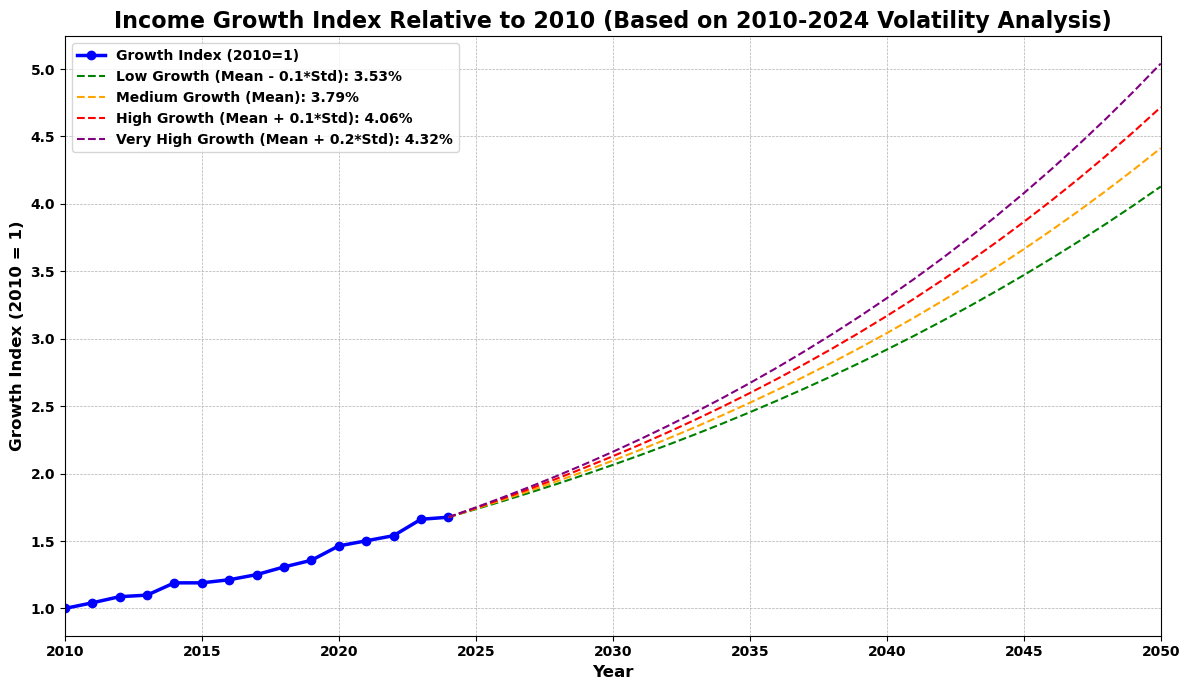

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 原始数据
years_str = [
    'Aug-97', 'Aug-98', 'Aug-99', 'Aug-00', 'Aug-01', 'Aug-02', 'Aug-03', 'Aug-04',
    'Aug-05', 'Aug-06', 'Aug-07', 'Aug-08', 'Aug-09', 'Aug-10', 'Aug-11', 'Aug-12',
    'Aug-13', 'Aug-14', 'Aug-15', 'Aug-16', 'Aug-17', 'Aug-18', 'Aug-19', 'Aug-20',
    'Aug-21', 'Aug-22', 'Aug-23', 'Aug-24'
]
hourly_income = [
    15.2, 15.8, 16.4, 17.1, 17.8, 18.7, 19.2, 20.0, 21.0, 21.8, 22.9, 24.3,
    25.0, 26.3, 27.4, 28.6, 28.9, 31.3, 31.3, 31.9, 32.9, 34.4, 35.7, 38.5,
    39.5, 40.5, 43.7, 44.1
]

# 2. 数据处理
years = [int(s.split('-')[1]) + (1900 if int(s.split('-')[1]) > 90 else 2000) for s in years_str]
df = pd.DataFrame({'Year': years, 'Hourly_Income': hourly_income})

# 3. 筛选2010-2024年的数据
df_period = df[df['Year'] >= 2010].copy()

# 4. 计算相对于2010年的“增长指数”
base_income_2010 = df_period[df_period['Year'] == 2010]['Hourly_Income'].iloc[0]
df_period['Growth_Index'] = df_period['Hourly_Income'] / base_income_2010

# 5. 基于2010-2024数据，进行统计分析以定义未来情景
# 计算2011-2024年间，每年的同比增长率
df_period['YoY_Growth'] = df_period['Hourly_Income'].pct_change()
# 计算这些年增长率的平均值和标准差
mean_growth = df_period['YoY_Growth'].mean()
std_dev_growth = df_period['YoY_Growth'].std()

print(f"2010-2024年期间的分析:")
print(f"年均增长率 (Mean): {mean_growth*100:.2f}%")
print(f"增长率标准差 (Std Dev): {std_dev_growth*100:.2f}%")

# 6. 使用统计结果构建四种未来增长情景 (更严谨的方法)
medium_growth = mean_growth
low_growth = mean_growth - 0.1 * std_dev_growth
high_growth = mean_growth + 0.1 * std_dev_growth
very_high_growth = mean_growth + 0.2 * std_dev_growth

print("\n基于数据波动性定义的四种未来增长情景:")
print(f"低增长情景 (Mean - 0.5*Std): {low_growth*100:.2f}%")
print(f"中等增长情景 (Mean): {medium_growth*100:.2f}%")
print(f"高增长情景 (Mean + 0.5*Std): {high_growth*100:.2f}%")
print(f"非常高增长情景 (Mean + 1.0*Std): {very_high_growth*100:.2f}%")


# 7. 准备未来预测
last_year = df_period['Year'].iloc[-1]
last_index = df_period['Growth_Index'].iloc[-1]
future_years = np.arange(last_year, 2051)

# 定义一个函数，用于从最后一个已知点开始，按给定的年增长率进行复利计算
def project_future_index(start_index, years_array, start_year, growth_rate):
    t = years_array - start_year
    return start_index * ((1 + growth_rate) ** t)

# 为四种情景分别计算预测的增长指数
low_pred = project_future_index(last_index, future_years, last_year, low_growth)
medium_pred = project_future_index(last_index, future_years, last_year, medium_growth)
high_pred = project_future_index(last_index, future_years, last_year, high_growth)
very_high_pred = project_future_index(last_index, future_years, last_year, very_high_growth)


# 8. 绘图
# 8. Plotting
plt.figure(figsize=(12, 7))

# Plot the historical growth index (solid line)
plt.plot(df_period['Year'], df_period['Growth_Index'], label='Growth Index (2010=1)', color='blue', linewidth=2.5, marker='o')

# Plot the four future scenarios (dashed lines)
plt.plot(future_years, low_pred, label=f'Low Growth (Mean - 0.1*Std): {low_growth*100:.2f}%', linestyle='--', color='green')
plt.plot(future_years, medium_pred, label=f'Medium Growth (Mean): {medium_growth*100:.2f}%', linestyle='--', color='orange')
plt.plot(future_years, high_pred, label=f'High Growth (Mean + 0.1*Std): {high_growth*100:.2f}%', linestyle='--', color='red')
plt.plot(future_years, very_high_pred, label=f'Very High Growth (Mean + 0.2*Std): {very_high_growth*100:.2f}%', linestyle='--', color='purple')


# 9. Set chart styles
plt.title('Income Growth Index Relative to 2010 (Based on 2010-2024 Volatility Analysis)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Growth Index (2010 = 1)', fontsize=12)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlim(2010, 2050)
plt.tight_layout()

# 10. Save and show the plot
plt.savefig('FLC_growth_index.png')
plt.show()

2010-2024年期间的分析:
年均增长率 (Mean): 0.51%
增长率标准差 (Std Dev): 3.43%

基于数据波动性定义的四种未来增长情景:
低增长情景 (Mean - 0.5*Std): 0.17%
中等增长情景 (Mean): 0.51%
高增长情景 (Mean + 0.5*Std): 0.85%
非常高增长情景 (Mean + 1.0*Std): 1.20%


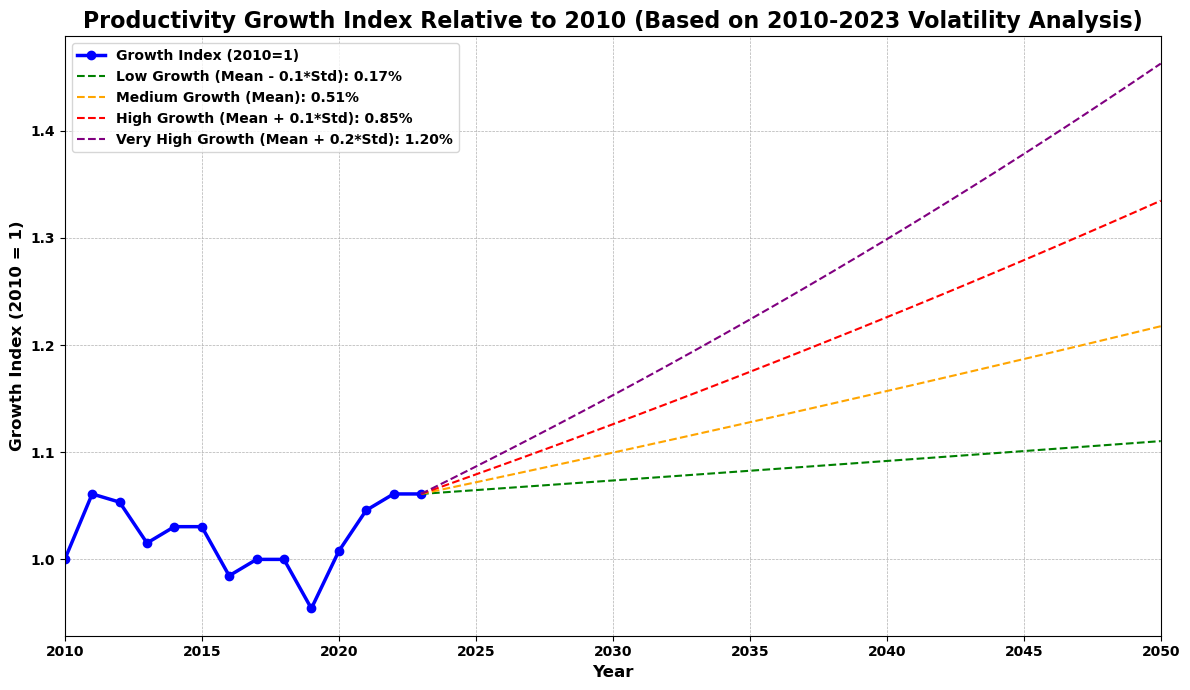

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

base_year = 2010
# 1. 原始数据
financial_year = ["1988-89", "1989-90", "1990-91", "1991-92", "1992-93", "1993-94", "1994-95", "1995-96", "1996-97", "1997-98", "1998-99", "1999-2000", "2000-01", "2001-02", "2002-03", "2003-04", "2004-05", "2005-06", "2006-07", "2007-08", "2008-09", "2009-10", "2010-11", "2011-12", "2012-13", "2013-14", "2014-15", "2015-16", "2016-17", "2017-18", "2018-19", "2019-20", "2020-21", "2021-22", "2022-23", "2023-24"]

all_australia = [103, 109, 114, 117, 118, 118, 122, 118, 118, 118, 118, 124, 116, 118, 113, 115, 117, 124, 126, 129, 129, 129, 131, 139, 138, 133, 135, 135, 129, 131, 131, 125, 132, 137, 139, 139]

# 2. 数据处理
years = [int(s.split('-')[0]) for s in financial_year]
df = pd.DataFrame({'Year': years, 'Hourly_Income': all_australia})

# 3. 筛选2010-2024年的数据
df_period = df[df['Year'] >= base_year].copy()

# 4. 计算相对于2010年的“增长指数”
base_income_2010 = df_period[df_period['Year'] == base_year]['Hourly_Income'].iloc[0]
df_period['Growth_Index'] = df_period['Hourly_Income'] / base_income_2010

# 5. 基于2010-2024数据，进行统计分析以定义未来情景
# 计算2011-2024年间，每年的同比增长率
df_period['YoY_Growth'] = df_period['Hourly_Income'].pct_change()
# 计算这些年增长率的平均值和标准差
mean_growth = df_period['YoY_Growth'].mean()
std_dev_growth = df_period['YoY_Growth'].std()

print(f"2010-2024年期间的分析:")
print(f"年均增长率 (Mean): {mean_growth*100:.2f}%")
print(f"增长率标准差 (Std Dev): {std_dev_growth*100:.2f}%")

# 6. 使用统计结果构建四种未来增长情景 (更严谨的方法)
medium_growth = mean_growth
low_growth = mean_growth - 0.1 * std_dev_growth
high_growth = mean_growth + 0.1 * std_dev_growth
very_high_growth = mean_growth + 0.2 * std_dev_growth

print("\n基于数据波动性定义的四种未来增长情景:")
print(f"低增长情景 (Mean - 0.5*Std): {low_growth*100:.2f}%")
print(f"中等增长情景 (Mean): {medium_growth*100:.2f}%")
print(f"高增长情景 (Mean + 0.5*Std): {high_growth*100:.2f}%")
print(f"非常高增长情景 (Mean + 1.0*Std): {very_high_growth*100:.2f}%")


# 7. 准备未来预测
last_year = df_period['Year'].iloc[-1]
last_index = df_period['Growth_Index'].iloc[-1]
future_years = np.arange(last_year, 2051)

# 定义一个函数，用于从最后一个已知点开始，按给定的年增长率进行复利计算
def project_future_index(start_index, years_array, start_year, growth_rate):
    t = years_array - start_year
    return start_index * ((1 + growth_rate) ** t)

# 为四种情景分别计算预测的增长指数
low_pred = project_future_index(last_index, future_years, last_year, low_growth)
medium_pred = project_future_index(last_index, future_years, last_year, medium_growth)
high_pred = project_future_index(last_index, future_years, last_year, high_growth)
very_high_pred = project_future_index(last_index, future_years, last_year, very_high_growth)


# 8. 绘图
# 8. Plotting
plt.figure(figsize=(12, 7))

# Plot the historical growth index (solid line)
plt.plot(df_period['Year'], df_period['Growth_Index'], label='Growth Index (2010=1)', color='blue', linewidth=2.5, marker='o')

# Plot the four future scenarios (dashed lines)
plt.plot(future_years, low_pred, label=f'Low Growth (Mean - 0.1*Std): {low_growth*100:.2f}%', linestyle='--', color='green')
plt.plot(future_years, medium_pred, label=f'Medium Growth (Mean): {medium_growth*100:.2f}%', linestyle='--', color='orange')
plt.plot(future_years, high_pred, label=f'High Growth (Mean + 0.1*Std): {high_growth*100:.2f}%', linestyle='--', color='red')
plt.plot(future_years, very_high_pred, label=f'Very High Growth (Mean + 0.2*Std): {very_high_growth*100:.2f}%', linestyle='--', color='purple')


# 9. Set chart styles
plt.title(f'Productivity Growth Index Relative to {base_year} (Based on {base_year}-2023 Volatility Analysis)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Growth Index (2010 = 1)', fontsize=12)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlim(base_year, 2050)
plt.tight_layout()

# 10. Save and show the plot
plt.savefig('productive_growth_index.png')
plt.show()